# Data preprocessing part and Collapsed Gibbs Sampling
## Download BBC news dataset from Kaggle
The dataset has been changed on the kaggle website after my midterm project. So I don't use download from kaggle directly in case it will change again. I downloaded the file and imported  it.

In [6]:
# import kagglehub
# 
# # Download latest version
# path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
# 
# print("Path to dataset files:", path)
# 
# import pandas as pd
# import os
# # List all files in the dataset directory
# print("Files in the dataset:")
# for file in os.listdir(path):
#     print(file)

In [21]:
import pandas as pd
import numpy as np

In [29]:
df = pd.read_csv("bbc_news_text_complexity_summarization.csv", usecols=[0,1])
df['labels'].unique() # check labeled topics

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [23]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [30]:
df['text'] = df['text'].astype(str)
df.shape

(2127, 2)

In [15]:
from collections import Counter
from tqdm import tqdm
from joblib import Parallel, delayed
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')  # Tokenizer
nltk.download('stopwords')  # Stopwords
nltk.download('wordnet')  # Lemmatizer
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /Users/gaosiyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gaosiyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gaosiyi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gaosiyi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Data preprocessing

1.   lowercase
2.   tokenize
3.   lemmatize
4.   remove stopwords



In [34]:
stop_words = set(stopwords.words('english'))
news_stopwords = {'say', 'said', 'also', 'report', 'news', 'year', 'would', 'wa', 'ha', 'u',
                   'mr', 'stayed', 'new', 'could', 'first', 'last', 'one', 'two', 'three', 'four', 'five', 'told', 'still', 'since', 'come', 'day'}
stop_words = stop_words.union(news_stopwords)
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens


In [35]:
df['clean_text'] = df['text'].apply(preprocess_text)
df_train = df.sample(frac=0.8, random_state=42) # split the dataset into train set and test set
df_test = df.drop(df_train.index)
print(f"Train set size: {df_train.shape}")
print(f"Test set size: {df_test.shape}")

import pickle
with open('df_train.pkl', 'wb') as file:
    pickle.dump(df_train, file)

# Save testing corpus
with open('df_test.pkl', 'wb') as file:
    pickle.dump(df_test, file)
    
train_clean_text = df_train['clean_text'].tolist()
test_clean_text = df_test['clean_text'].tolist()

Train set size: (1702, 3)
Test set size: (425, 3)


In [45]:
df_train.head()

,text,labels,clean_text
282,EU 'too slow' on economic reforms\n\nMost EU c...,business,"[eu, slow, economic, reform, eu, country, fail..."
1999,BBC web search aids odd queries\n\nThe BBC's o...,tech,"[bbc, web, search, aid, odd, query, bbc, onlin..."
1709,Serena becomes world number two\n\nSerena Will...,sport,"[serena, becomes, world, number, serena, willi..."
988,Boothroyd calls for Lords speaker\n\nBetty Boo...,politics,"[boothroyd, call, lord, speaker, betty, boothr..."
2018,Fast lifts rise into record books\n\nTwo high-...,tech,"[fast, lift, rise, record, book, lift, world, ..."


store the training and testing set as pickle file, which is going to be used in other file in training the variational em algorithm. This step is to make sure two method using the exactly same dataset.


In [72]:
def construct_corpus(clean_text):
    word_to_id = {}  # Store unique word-ID pairs
    current_id = 0
    for text in clean_text:
        for word in text:
            if word not in word_to_id:
                word_to_id[word] = current_id
                current_id += 1

    corpus = []
    for text in clean_text:
        word_counts = Counter(text)
        count_freq = [(word_to_id[word], freq) for word, freq in word_counts.items()]
        corpus.append(count_freq)

    return corpus, word_to_id

train_corpus, train_word_to_id = construct_corpus(train_clean_text)

print(f"Number of documents in training set: {len(train_corpus)}")
print(f"Number of unique words in training set: {len(train_word_to_id)}")

# construct the testing set corpus using the training vocabulary encoding index to make sure word indexes are consistent
def construct_corpus_with_training_vocab(clean_text, word_to_id):
    corpus = []
    for text in clean_text:
        word_counts = Counter(text)
        count_freq = [
            (word_to_id[word], freq) for word, freq in word_counts.items() if word in word_to_id
        ]
        corpus.append(count_freq)
    return corpus

test_corpus = construct_corpus_with_training_vocab(test_clean_text, train_word_to_id)
print(f"Number of documents in test set: {len(test_corpus)}")

Number of documents in training set: 1702
Number of unique words in training set: 21927
Number of documents in test set: 425


# Implement collapsed gibbs sampling with training dataset, run 500 iterations, and display the top 10 frequent words in each topic

In [73]:
def LDA_collapsed_gibbs(corpus, vocab, num_topics, alpha=0.1, beta=0.1, n_iters=100):
    # initialize matrices to store counts
    D = len(corpus) # Number of documents
    W = len(vocab) # Number of total unique words
    C_dk = np.zeros((D, num_topics)) # Number of words in document d assigned to topic k
    C_kw = np.zeros((num_topics, W)) # Number of times word w assigned to topic k
    C_k = np.zeros(num_topics)  # Total number of words assigned to topic k
    Z = [] # List to store topic assignments for each word

    # Initialize topic assignments randomly
    for doc_idx, doc in enumerate(corpus):
        doc_topics = []  # Store topic assignments for the current document
        for i, (word_idx, freq) in enumerate(doc): # i represents the ith word in the document, word_idx is the word index for the word in vocabulary, which is used to retrieve the original word
            topic = np.random.randint(0, num_topics)  # Random topic assignment
            doc_topics.append(topic) # Store topic assignments for each word in the document

            # Update counts based on the initial topic assignment
            C_dk[doc_idx, topic] += freq
            C_kw[topic, word_idx] += freq
            C_k[topic] += freq

        Z.append(doc_topics) # Store topic assignments for each document

    # loops
    for _ in tqdm(range(n_iters), desc="Gibbs Sampling"):
        for doc_idx, doc in enumerate(corpus):
            for i, (word_idx, freq) in enumerate(doc):
                current_topic = Z[doc_idx][i] # get the current topic for the ith word in the document

                # remove z_i because conditioned on z_(-i)
                C_dk[doc_idx, current_topic] -= freq
                C_kw[current_topic, word_idx] -= freq
                C_k[current_topic] -= freq

                # Sample a new topic
                new_probs = (C_dk[doc_idx, :] + alpha)/ (C_dk[doc_idx, :].sum() + num_topics * alpha) * (C_kw[:, word_idx] + beta) / (C_k[:] + W * beta)
                standardized_new_probs = new_probs / new_probs.sum()

                # Assign new topic
                new_topic = np.argmax(np.random.multinomial(1, standardized_new_probs))

                # Increment counter with new assignment
                Z[doc_idx][i] = new_topic
                C_dk[doc_idx, new_topic] += freq
                C_kw[new_topic, word_idx] += freq
                C_k[new_topic] += freq

    return C_dk, C_kw, C_k, Z

def display_topics(C_kw, id_to_word, num_words=10):
    for topic in range(C_kw.shape[0]):
        top_words = np.argsort(C_kw[topic])[::-1][:num_words]
        topic_words = [id_to_word[word_id] for word_id in top_words]
        print(f"Topic {topic}: {', '.join(topic_words)}")

In [74]:
#training
C_dk, C_kw, C_k, Z = LDA_collapsed_gibbs(train_corpus, train_word_to_id, num_topics=5, alpha=0.1, beta=0.1, n_iters=500)

Gibbs Sampling: 100%|██████████| 500/500 [14:20<00:00,  1.72s/it]


In [75]:
train_id_to_word = {v: k for k, v in train_word_to_id.items()}
display_topics(C_kw, train_id_to_word)

Topic 0: company, market, firm, bank, economy, price, share, sale, growth, business
Topic 1: film, best, award, show, star, music, actor, band, number, director
Topic 2: people, game, technology, service, phone, mobile, user, net, computer, make
Topic 3: game, win, england, player, world, club, time, play, back, team
Topic 4: government, people, labour, party, election, minister, blair, plan, tory, brown


# perform prediction on testing set

In [76]:
def calculate_C_dk_test(corpus_test, num_topics, C_kw, C_k, vocab_size_train, alpha, beta, n_iters=50):
    
    D_test = len(corpus_test)  # Number of documents in the test corpus
    C_dk_test = np.zeros((D_test, num_topics))  # Initialize document-topic counts
    Z_test = []  # Store topic assignments for each word in the test corpus

    # Initialize random topic assignments for the test set
    for doc_idx, doc in enumerate(corpus_test):
        doc_topics = []
        for word_idx, freq in doc:
            topic = np.random.randint(0, num_topics)  # Random topic assignment
            doc_topics.append(topic)
            C_dk_test[doc_idx, topic] += freq  # Update document-topic counts
        Z_test.append(doc_topics)

    # Perform Gibbs sampling for the test set
    for _ in tqdm(range(n_iters), desc="Gibbs Sampling for Test Set"):
        for doc_idx, doc in enumerate(corpus_test):
            for i, (word_idx, freq) in enumerate(doc):
                current_topic = Z_test[doc_idx][i]

                # Decrement counts for current topic
                C_dk_test[doc_idx, current_topic] -= freq

                # Calculate topic probabilities
                topic_probs = (
                    (C_dk_test[doc_idx, :] + alpha) /
                    (C_dk_test[doc_idx, :].sum() + num_topics * alpha)
                ) * (
                    (C_kw[:, word_idx] + beta) /
                    (C_k + vocab_size_train * beta)
                )
                topic_probs /= topic_probs.sum()  # Normalize to get probabilities

                # Sample new topic
                new_topic = np.argmax(np.random.multinomial(1, topic_probs))
                Z_test[doc_idx][i] = new_topic

                # Increment counts for the new topic
                C_dk_test[doc_idx, new_topic] += freq

    return C_dk_test


In [77]:
C_dk_test = calculate_C_dk_test(
    corpus_test=test_corpus,
    num_topics=5,
    C_kw=C_kw,
    C_k=C_k,
    vocab_size_train=len(train_word_to_id),
    alpha=0.1,
    beta=0.1,
    n_iters=50
)

Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


# calculate perplexity

In [78]:
def calculate_perplexity(test_corpus, C_dk_test, C_kw, C_k, vocab_size_train, alpha, beta, total_test_word_count):

    # Calculate topic-word probabilities (P(w|z))
    P_w_given_z = (C_kw + beta) / (C_k[:, np.newaxis] + vocab_size_train * beta)
    
    # Initialize variables for log likelihood
    log_likelihood = 0

    # Loop over each document in the test corpus
    for doc_idx, doc in enumerate(test_corpus):
        # Get document-topic probabilities (P(z|d))
        P_z_given_d = (C_dk_test[doc_idx, :] + alpha) / (C_dk_test[doc_idx, :].sum() + len(C_kw) * alpha)

        # Compute log likelihood for each word
        for word_idx, freq in doc:
            # Calculate P(w) as the weighted sum over topics
            P_word = np.dot(P_z_given_d, P_w_given_z[:, word_idx])
            if P_word > 0:
                log_likelihood += freq * np.log(P_word)

    # Calculate perplexity
    perplexity = np.exp(-log_likelihood / total_test_word_count)
    return perplexity


In [79]:
total_test_word_count = sum(len(doc) for doc in test_clean_text)  # Total words, including unseen ones
# Calculate perplexity for the test set
perplexity = calculate_perplexity(
    test_corpus=test_corpus,
    C_dk_test=C_dk_test,
    C_kw=C_kw,
    C_k=C_k,
    vocab_size_train=len(train_word_to_id),
    alpha=0.1,
    beta=0.1,
    total_test_word_count=total_test_word_count
)
print(f"Perplexity: {perplexity}")

Perplexity: 2121.7104640160596


# Illustrate the idea of LDA

In [95]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import nltk
from nltk.tokenize import word_tokenize

row_idx = 9 # Index of the row to visualize
original_text = df_train.iloc[row_idx]["text"]  # Original text
processed_text = df_train.iloc[row_idx]["clean_text"]  # Processed clean text
word_topics = Z[row_idx]  # Topic assignments from Gibbs Sampling (aligned with processed_text)

# Define topic colors
topic_colors = {
    0: "red",
    1: "blue",
    2: "green",
    3: "purple",
    4: "orange"  # Extend as needed
}

# Tokenize the original text
original_tokens = word_tokenize(original_text.lower())

# Function to align topics with original text
def align_and_color_text(original_tokens, processed_text, word_topics, topic_colors):

    # Create a mapping of processed words to their topics
    processed_topic_map = dict(zip(processed_text, word_topics))
    
    # Highlight each word in the original text
    colored_text = []
    for word in original_tokens:
        # Check if the word exists in the processed text and has a topic
        topic = processed_topic_map.get(word, None)
        if topic is not None:  # If the word has a topic assignment
            color = topic_colors.get(topic, "black")
            colored_text.append(f'<span style="color: {color};">{word}</span>')
        else:
            # No topic assigned, keep the word in default color (black)
            colored_text.append(word)
    
    return " ".join(colored_text)

# Generate the colored HTML
colored_html = align_and_color_text(original_tokens, processed_text, word_topics, topic_colors)

# Display the colored text
display(HTML(f"<p style='font-size: 16px;'>{colored_html}</p>"))


[nltk_data] Downloading package punkt to /Users/gaosiyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [96]:
original_text

'Glazer makes new Man Utd approach\n\nMalcolm Glazer has made a fresh approach to buy Manchester United, which could lead to a bid valuing the Premiership club at £800m.\n\nThe US tycoon, who has been wooing the club for the last 12 months, has approached the United board with "detailed proposals", it has confirmed. Mr Glazer, who owns the Tampa Bay Buccaneers team, hopes this will lead to a formal bid being accepted. His new offer is expected to contain substantially less debt. Mr Glazer has already had one takeover attempt turned down by the Red Devils and responded by using his 28.1% shareholding to vote off three board members last November.\n\nMan United had turned down the bid because it was based on a high level of borrowing. But newspapers have speculated recently that the tycoon had gained the support of leading banks to come up with a stronger and less debt-laden bid. Last week, however, Mr Glazer issued a statement to the Stock Exchange distancing himself from a new bid.\n\n

In [97]:
df_train.iloc[row_idx]["labels"]

'business'

# Experiments
## num_topics = [2,5,10,20,50,100]

In [83]:
def experiment_varying_topics(
    train_corpus, test_corpus, train_word_to_id, total_test_word_count, 
    num_topics_list, alpha=0.1, beta=0.1, train_iters=500, test_iters=50):

    perplexity_results = {}

    for num_topics in num_topics_list:
        print(f"Training LDA model with {num_topics} topics...")
        
        # Initialize and train LDA model on training corpus
        C_dk_train, C_kw, C_k, Z_train = LDA_collapsed_gibbs(
            corpus=train_corpus,
            vocab=train_word_to_id,
            num_topics=num_topics,
            alpha=alpha,
            beta=beta,
            n_iters=train_iters
        )

        # Calculate document-topic matrix for test corpus
        print(f"Evaluating perplexity for {num_topics} topics...")
        C_dk_test = calculate_C_dk_test(
            corpus_test=test_corpus,
            num_topics=num_topics,
            C_kw=C_kw,
            C_k=C_k,
            vocab_size_train=len(train_word_to_id),
            alpha=alpha,
            beta=beta,
            n_iters=test_iters
        )

        # Compute perplexity for the test set
        perplexity = calculate_perplexity(
            test_corpus=test_corpus,
            C_dk_test=C_dk_test,
            C_kw=C_kw,
            C_k=C_k,
            vocab_size_train=len(train_word_to_id),
            alpha=alpha,
            beta=beta,
            total_test_word_count=total_test_word_count
        )
        print(f"Perplexity for {num_topics} topics: {perplexity}")

        # Store perplexity result
        perplexity_results[num_topics] = perplexity

    return perplexity_results


In [84]:
num_topics_list = [2, 5, 10, 20, 50]
perplexity_results = experiment_varying_topics(
    train_corpus=train_corpus,
    test_corpus=test_corpus,
    train_word_to_id=train_word_to_id,
    total_test_word_count=total_test_word_count,
    num_topics_list=num_topics_list,
    alpha=0.1,
    beta=0.1,
    train_iters=500,
    test_iters=50
)


Training LDA model with 2 topics...


Gibbs Sampling: 100%|██████████| 500/500 [13:45<00:00,  1.65s/it]


Evaluating perplexity for 2 topics...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


Perplexity for 2 topics: 2738.653230876155
Training LDA model with 5 topics...


Gibbs Sampling: 100%|██████████| 500/500 [13:57<00:00,  1.67s/it]


Evaluating perplexity for 5 topics...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Perplexity for 5 topics: 2120.7774978379084
Training LDA model with 10 topics...


Gibbs Sampling: 100%|██████████| 500/500 [14:04<00:00,  1.69s/it]


Evaluating perplexity for 10 topics...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


Perplexity for 10 topics: 1955.1987706868235
Training LDA model with 20 topics...


Gibbs Sampling: 100%|██████████| 500/500 [14:23<00:00,  1.73s/it]


Evaluating perplexity for 20 topics...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


Perplexity for 20 topics: 1799.5026826660248
Training LDA model with 50 topics...


Gibbs Sampling: 100%|██████████| 500/500 [15:12<00:00,  1.82s/it]


Evaluating perplexity for 50 topics...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]

Perplexity for 50 topics: 1739.3602543508403


In [85]:
perplexity_result_100 = experiment_varying_topics(
    train_corpus=train_corpus,
    test_corpus=test_corpus,
    train_word_to_id=train_word_to_id,
    total_test_word_count=total_test_word_count,
    num_topics_list=[100],
    alpha=0.1,
    beta=0.1,
    train_iters=500,
    test_iters=50
)

Training LDA model with 100 topics...


Gibbs Sampling: 100%|██████████| 500/500 [16:39<00:00,  2.00s/it]


Evaluating perplexity for 100 topics...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]

Perplexity for 100 topics: 1787.521755190112


In [87]:
perplexity_result_100

{100: 1787.521755190112}

In [114]:
combined_perplexities = perplexity_results.copy()
combined_perplexities.update(perplexity_result_100)
print(combined_perplexities)

{2: 2738.653230876155, 5: 2120.7774978379084, 10: 1955.1987706868235, 20: 1799.5026826660248, 50: 1739.3602543508403, 100: 1787.521755190112}


# Draw perplexity plot for two methods

Plot saved as perplexity_vs_topics.png


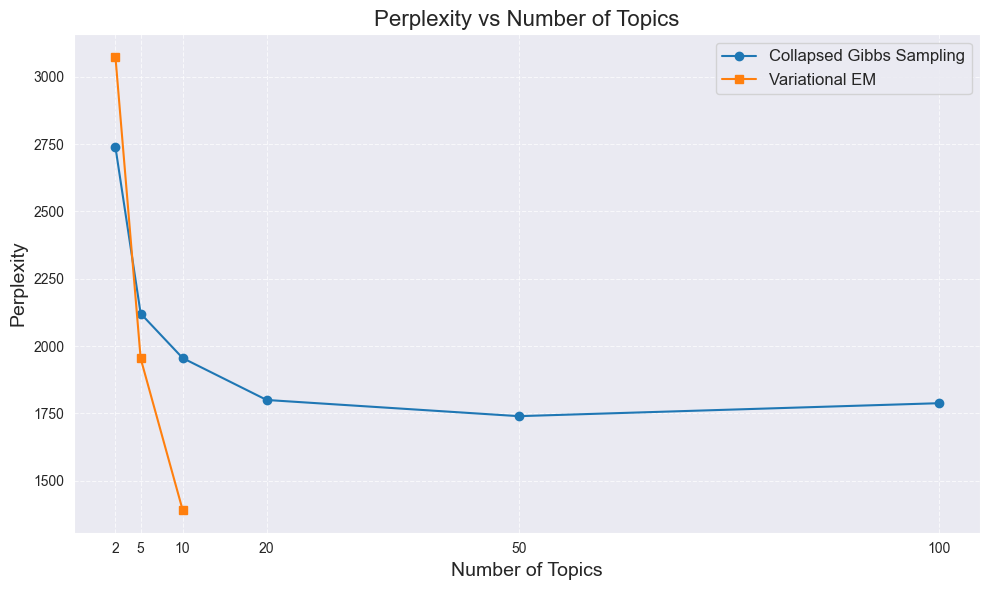

In [131]:
perplexity_em = {2:3073.6158, 5: 1953.9353, 10:1390.4193}
perplexity_gibbs = combined_perplexities

topics_gibbs = list(perplexity_gibbs.keys())
values_gibbs = list(perplexity_gibbs.values())

topics_em = list(perplexity_em.keys())
values_em = list(perplexity_em.values())

plt.figure(figsize=(10, 6))
plt.plot(topics_gibbs, values_gibbs, marker='o', label='Collapsed Gibbs Sampling')
plt.plot(topics_em, values_em, marker='s', label='Variational EM')

plt.title('Perplexity vs Number of Topics', fontsize=16)
plt.xlabel('Number of Topics', fontsize=14)
plt.ylabel('Perplexity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(sorted(set(topics_gibbs + topics_em)))  

output_file = "perplexity_vs_topics.png"
plt.savefig(output_file, dpi=300) 
print(f"Plot saved as {output_file}")

plt.tight_layout()
plt.show()

# Use collapsed gibbs sampling first and then perform svm

## experiments
## proportion: [0.05, 0.1, 0.25, 0.4, 0.5, 0.75]

In [105]:
import random

def split_training_and_testing_from_df(df, proportion):
    # Calculate the number of samples for the training set
    num_train_samples = int(len(df) * proportion)
    
    # Randomly sample indices for the training set
    train_indices = random.sample(range(len(df)), num_train_samples)
    
    # Create training and testing DataFrames
    train_df = df.iloc[train_indices]
    test_df = df.drop(df.index[train_indices])  
    
    return train_df, test_df


In [106]:
def construct_corpus_and_vocabulary(df_train, df_test):
    train_clean_text = df_train["clean_text"].tolist()
    test_clean_text = df_test["clean_text"].tolist()
    train_corpus, train_word_to_id = construct_corpus(train_clean_text)
    test_corpus = construct_corpus_with_training_vocab(test_clean_text, train_word_to_id)
    return train_corpus, test_corpus, train_word_to_id

def get_document_topic_distributions(corpus, C_dk, alpha)
    num_topics = C_dk.shape[1]
    doc_topic_distributions = (C_dk + alpha) / (C_dk.sum(axis=1, keepdims=True) + num_topics * alpha)
    return doc_topic_distributions


In [121]:
from sklearn.feature_extraction.text import CountVectorizer  # Use CountVectorizer for raw word features
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

proportions = [0.05, 0.1, 0.25, 0.4, 0.5, 0.75]
lda_accuracies = []
raw_word_accuracies = []

# Train LDA and SVM for each training proportion
for proportion in proportions:
    print(f"\nTraining with {proportion * 100:.0f}% of the training data...")

    # Sample a proportion of the training data
    train_set, test_set = split_training_and_testing_from_df(df, proportion)
    train_corpus, test_corpus, train_word_to_id = construct_corpus_and_vocabulary(train_set, test_set)

    # Train LDA on the sampled training data
    num_topics = 10
    alpha = 0.1
    beta = 0.1
    C_dk_train, C_kw, C_k, Z_train = LDA_collapsed_gibbs(
        corpus=train_corpus,
        vocab=train_word_to_id,
        num_topics=num_topics,
        alpha=alpha,
        beta=beta,
        n_iters=500
    )

    # Compute document-topic distributions for training data
    doc_topic_train = get_document_topic_distributions(train_corpus, C_dk_train, alpha)

    # For simplicity, test on the full dataset (test_corpus is all rows here)
    C_dk_test = calculate_C_dk_test(
        corpus_test=test_corpus,
        num_topics=num_topics,
        C_kw=C_kw,
        C_k=C_k,
        vocab_size_train=len(train_word_to_id),
        alpha=alpha,
        beta=beta,
        n_iters=50
    )
    doc_topic_test = get_document_topic_distributions(test_corpus, C_dk_test, alpha)
    
    train_labels = train_set["labels"].tolist()
    test_labels = test_set["labels"].tolist()

    # Train SVM on LDA features
    svm_lda = SVC(kernel='linear', random_state=42)
    svm_lda.fit(doc_topic_train, train_labels)

    # Predict and evaluate
    y_pred_lda = svm_lda.predict(doc_topic_test)
    lda_accuracy = accuracy_score(test_labels, y_pred_lda)
    lda_accuracies.append(lda_accuracy)
    print(f"Accuracy for {proportion * 100:.0f}% training data (LDA features): {lda_accuracy:.4f}")
    
    # Train SVM on raw word features
    train_texts = train_set["clean_text"].apply(lambda tokens: ' '.join(tokens)).tolist()
    test_texts = test_set["clean_text"].apply(lambda tokens: ' '.join(tokens)).tolist()

    # Transform raw text into raw word count features
    vectorizer = CountVectorizer(max_features=8000)  
    X_train_raw = vectorizer.fit_transform(train_texts)
    X_test_raw = vectorizer.transform(test_texts)

    # Train SVM on raw word features
    svm_word = SVC(kernel='linear', random_state=42)
    svm_word.fit(X_train_raw, train_labels)

    # Predict and evaluate on the test set
    y_pred_word = svm_word.predict(X_test_raw)
    raw_word_accuracy = accuracy_score(test_labels, y_pred_word)
    raw_word_accuracies.append(raw_word_accuracy)

    print("SVM with Raw Word Features")
    print(f"Accuracy: {raw_word_accuracy:.4f}")



Training with 5% of the training data...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


Accuracy for 5% training data (LDA features): 0.8619
SVM with Raw Word Features
Accuracy: 0.8268

Training with 10% of the training data...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


Accuracy for 10% training data (LDA features): 0.9264
SVM with Raw Word Features
Accuracy: 0.9018

Training with 25% of the training data...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


Accuracy for 25% training data (LDA features): 0.9311
SVM with Raw Word Features
Accuracy: 0.9411

Training with 40% of the training data...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


Accuracy for 40% training data (LDA features): 0.9444
SVM with Raw Word Features
Accuracy: 0.9554

Training with 50% of the training data...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Accuracy for 50% training data (LDA features): 0.9455
SVM with Raw Word Features
Accuracy: 0.9615

Training with 75% of the training data...


Gibbs Sampling for Test Set: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Accuracy for 75% training data (LDA features): 0.9586
SVM with Raw Word Features
Accuracy: 0.9624


In [128]:
lda_accuracies

[0.8619495299356754,
 0.9263707571801567,
 0.931077694235589,
 0.9444009397024276,
 0.9454887218045113,
 0.9586466165413534]

In [129]:
raw_word_accuracies

[0.8268184067293419,
 0.9018276762402089,
 0.9411027568922306,
 0.9553641346906813,
 0.9614661654135338,
 0.9624060150375939]

Plot saved as accuracy_vs_training_proportion.png


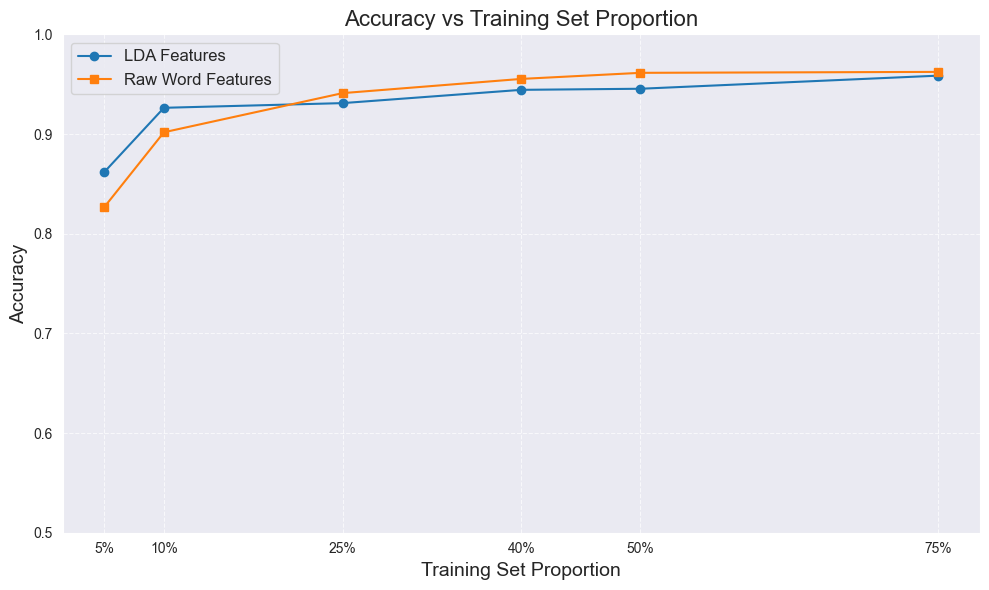

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(proportions, lda_accuracies, marker='o', label='LDA Features')
plt.plot(proportions, raw_word_accuracies, marker='s', label='Raw Word Features')

plt.title('Accuracy vs Training Set Proportion', fontsize=16)
plt.xlabel('Training Set Proportion', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(proportions, [f"{p*100:.0f}%" for p in proportions])  
plt.ylim(0.5, 1.0) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

plot_filename = "accuracy_vs_training_proportion.png" 
plt.savefig(plot_filename, dpi=300)  
print(f"Plot saved as {plot_filename}")

plt.show()

In [124]:
X_train_raw.shape

(1595, 8000)

In [125]:
doc_topic_train.shape

(1595, 10)

In [118]:
X_train_raw_dense = X_train_raw[:5].toarray() 
print(X_train_raw_dense)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Smoothed LDA

not include in the final report

In [ ]:
docs = train_corpus      
W = len(train_word_to_id)
k = K  # number of topics
N = np.array([sum(freq for _, freq in doc) for doc in train_corpus]) 
D = len(docs)

alpha = np.random.gamma(100, 0.01, k)
eta = np.ones(W)

# initialize variational parameters
# ϕ: (M x max(N) x k) arrays with zero paddings on the right
phi = [np.ones((N[d], k)) / k for d in range(D)]
gamma = alpha + (N / k).reshape(-1, 1)
lam = np.random.gamma(shape=100, scale=0.01, size=(k, W))
    
    
def update_phi(D, N, k, phi, gamma, docs):
    """
    Update variational parameter phi
    ϕ_{n, j} ∝ e^[ (Ψ(λ_j) - Ψ(Σλ_j)) + ( Ψ(γ_j) - Ψ(Σγ_j) ) ]
    """

    for d in range(D):
        for n in range(N[d]):
            for i in range(k):
                w_n = int(docs[d][n])
                phi[d][n, i] = np.exp(dl(lam, i, w_n) + dg(gamma, d, i))

            # Normalize over topics
            phi[d][n, :] = phi[d][n, :] / np.sum(phi[d][n, :])
            
    return phi

def update_gamma(D, phi, alpha):
    """
    Update variational parameter gamma
    γ_t = α_t + Σ_{n=1}^{N_d} ϕ_{t, n}
    """

    gamma = alpha + np.array(
        list(map(lambda x: x.sum(axis=0), phi))
    )
    
    return gamma


def update_lam(W, N, D, phi, lam, eta, docs):
    
    lam[:] = eta
    for d in range(D):  #, desc="MINORIZE lam"):
        doc = np.zeros(N[d] * W, dtype=int)
        doc[np.arange(0, N[d] * W, W) + docs[d]] = 1
        doc = doc.reshape(-1, W)
        
        lam += phi[d].T @ doc
    
    return lam
    

def update_alpha(D, k, old_alpha, gamma, max_iter=1000, tol=0.1):
    """
    Update alpha with linear time Newton-Raphson.
    """

    alpha = old_alpha

    for _ in range(max_iter):
        alpha_old = alpha

        #  Calculate gradient
        g = D * (psi(np.sum(alpha)) - psi(alpha)) +\
            (psi(gamma) - psi(np.sum(gamma, axis=1)).reshape(-1, 1)).sum(axis=0)

        #  Calculate Hessian diagonal component
        h = -D * polygamma(1, alpha)

        #  Calculate Hessian constant component
        z = D * polygamma(1, np.sum(alpha))

        #  Calculate constant
        c = np.sum(g / h) / (z ** (-1.0) + np.sum(h ** (-1.0)))

        #  Update alpha
        alpha = alpha - (g - c) / h
        
        #  Check convergence
        if np.sqrt(np.mean(np.square(alpha - alpha_old))) < tol:
            break
    else:
        warnings.warn("_update_alpha(): max_iter reached.")

    return alpha


def update_eta(D, k, old_eta, lam, max_iter=1000, tol=0.1):
    """
    Update eta with linear time Newton-Raphson.
    """
    eta = old_eta

    for _ in range(max_iter):
        eta_old = eta

        #  Calculate gradient
        g = k * (psi(np.sum(eta)) - psi(eta)) +\
            (psi(lam) - psi(np.sum(lam, axis=1)).reshape(-1, 1)).sum(axis=0)

        #  Calculate Hessian diagonal component
        h = -k * polygamma(1, eta)

        #  Calculate Hessian constant component
        z = k * polygamma(1, np.sum(eta))

        #  Calculate constant
        c = np.sum(g / h) / (z ** (-1.0) + np.sum(h ** (-1.0)))

        #  Update alpha
        eta = eta - (g - c) / h

        #  Check convergence
        if np.sqrt(np.mean(np.square(eta - eta_old))) < tol:
            break
    else:
        warnings.warn("_update_eta(): max_iter reached.")

    return eta


def E_step(D, N, k, eta, alpha, old_phi, old_gamma, old_lam, docs):
    """
    E-step of the variational EM algorithm.
    Update ϕ, γ, λ.
    """
    phi = update_phi(D, N, k, old_phi, old_gamma, docs)
    gamma = update_gamma(D, phi, alpha)
    lam = update_lam(W, N, D, phi, old_lam, eta, docs)
    return phi, gamma, lam
    
    
def M_step(D, k, gamma, old_alpha, old_eta):
    """
    M-step of the variational EM algorithm.
    Update α, η.
    """
    alpha = update_alpha(D, k, old_alpha, gamma)
    eta = update_eta(D, k, old_eta)
    return alpha, eta


def vlb(D, N, k, phi, gamma, lam, alpha, eta, docs):
    """
    lower bound from variational inference
    """
    
    a0, a1, a2, a3_1, a3_2, a4, a5 = 0., 0., 0., 0., 0., 0., 0.
    for d in range(D):
        a0 += (
            k * (
                gammaln(np.sum(eta)) 
                - np.sum(gammaln(eta))
            )
            + np.sum([(eta[j] - 1) * dl(lam, i, j) for j in range(W) for i in range(k)])
        )
        a1 += (
            gammaln(np.sum(alpha))
            - np.sum(gammaln(alpha))
            + np.sum([(alpha[i] - 1) * dg(gamma, d, i) for i in range(k)])
        )

        a4 += (
            gammaln(np.sum(gamma[d, :]))
            - np.sum(gammaln(gamma[d, :]))
            + np.sum([(gamma[d, i] - 1) * dg(gamma, d, i) for i in range(k)])
        )
        
        for i in range(k):
            for j in range(W):
                a3_2 += (
                    gammaln(np.sum(lam[i, j]))
                    - np.sum(gammaln(lam[i, :]))
                    + np.sum((lam[i, j] - 1) * dl(lam, i, j))
                )

        for n in range(N[d]):
            w_n = int(docs[d][n])
            a2 += np.sum([phi[d][n, i] * dg(gamma, d, i) for i in range(k)])
            a3_1 += np.sum([phi[d][n, i] * dl(lam, i, w_n) for i in range(k)])
            a5 += np.sum([phi[d][n, i] * np.log(phi[d][n, i]) for i in range(k)])

    return a0 + a1 + a2 + a3_1 - a3_2 - a4 - a5


def smoothLDA(max_iter=1000, tol=5, verbose=True):
    vlb = -np.inf
    
    for it in range(max_iter):
        old_vlb = vlb
        phi, gamma, lam = E_step(D, N, k, eta, alpha, phi, gamma, lam, docs)
        alpha, eta = M_step(D, k, gamma, alpha, eta)
        
        vlb = vlb(D, N, k, phi, gamma, lam, alpha, eta, docs)
        err = vlb - old_vlb
        
        if verbose:
            print(f"Iteration {it+1}: {vlb: .3f} (delta: {err: .2f})") 
        
        if err < tol:
            break
    else:
        warnings.warn("max_iter reached.")